=== ISO / IEEE Hill-Climbing Security Evaluation (T4) ===
Loaded 100 subjects with 8 impressions each.
Baseline EER = 1.0000, AUC = 0.0000


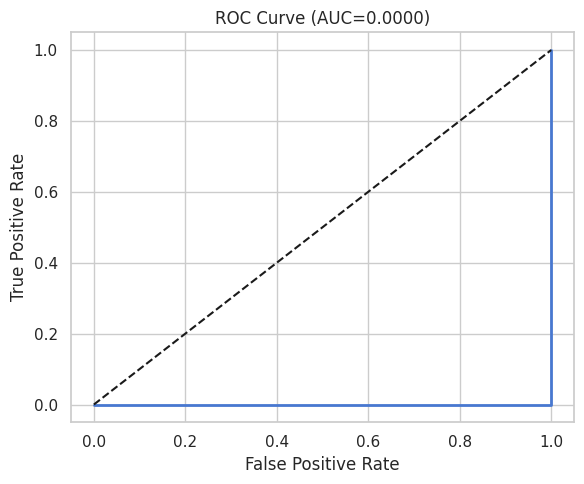


[Hill-Climbing] Running attacks...


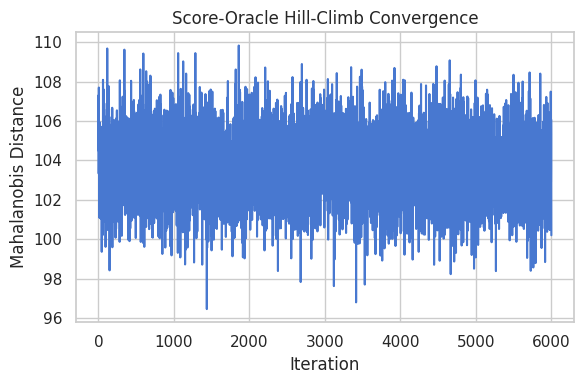

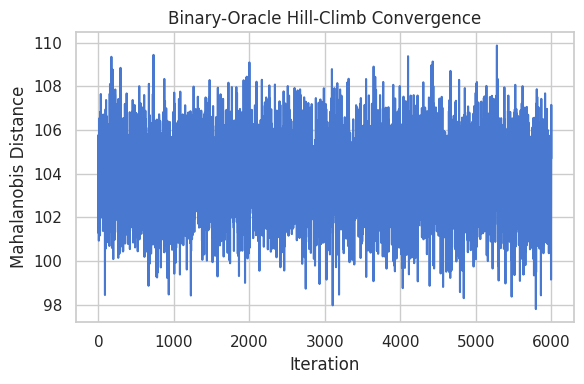


--- ISO/IEEE Hill-Climbing Security Summary (T4) ---
Attack Type     Success  Distance   Queries 
---------------------------------------------
Score-Oracle    False    96.4470    6000    
Binary-Oracle   False    97.7921    6000    

Interpretation:
- If success=False and distances remain high → robust against hill-climbing (ISO T4).
- If success=True quickly → vulnerability (attacker found a close feature).


In [ ]:
# Hill climbing attack

import os
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.metrics import roc_curve, auc
from sklearn.covariance import LedoitWolf
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten

# -------------------
# Configuration
# -------------------
IMAGE_SIZE = (224, 224)
DATASET_PATH = "/kaggle/input/fycalldaatsetsss/74034_3_En_4_MOESM1_ESM/FVC2000/Dbs/Db2_a"
NUM_SUBJECTS = 100
NUM_IMPRESSIONS = 8
ENROLL_IMPRESSIONS = 3
RANDOM_SEED = 42
HILLCLIMB_ITER = 2000
HILLCLIMB_RESTARTS = 3

# Reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# -------------------
# Dataset Loader
# -------------------
def load_dataset(dataset_path):
    subjects = {}
    for file in sorted(os.listdir(dataset_path)):
        if not file.lower().endswith((".tif", ".png", ".jpg")):
            continue
        parts = file.split("_")
        if len(parts) < 2:
            continue
        try:
            subj = int(parts[0])
        except:
            continue
        img = cv2.imread(os.path.join(dataset_path, file))
        if img is None:
            continue
        img = cv2.resize(img, IMAGE_SIZE)
        subjects.setdefault(subj, []).append(img)
    # Keep only subjects with exact number of impressions
    for s in list(subjects.keys()):
        if len(subjects[s]) != NUM_IMPRESSIONS:
            del subjects[s]
    subj_keys = sorted(subjects.keys())[:NUM_SUBJECTS]
    return {k: np.array(subjects[k]) for k in subj_keys}

# -------------------
# Feature Extraction
# -------------------
def build_feature_extractor():
    base = MobileNet(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + (3,))
    base.trainable = False
    return Sequential([base, GlobalAveragePooling2D(), Flatten()])

def extract_features(model, images):
    imgs = preprocess_input(images.astype("float32"))
    return model.predict(imgs, verbose=0, batch_size=32)

# -------------------
# PKBT Transformation
# -------------------
def apply_pkbt(features, key=None):
    if key is None or len(key) != features.shape[1]:
        key = np.random.randint(1, 255, (features.shape[1],), dtype=np.uint8)
    analytic_signal = hilbert(features, axis=1)
    magnitude = np.abs(analytic_signal)
    phase = np.angle(analytic_signal)
    expanded_key = np.tile(key, (features.shape[0], 1))
    mod_phase = (phase + expanded_key / 255.0) % (2 * np.pi)
    transformed = magnitude * np.exp(1j * mod_phase)
    return np.real(transformed), key

def center_and_l2normalize(X):
    Xc = X - np.mean(X, axis=0, keepdims=True)
    norms = np.linalg.norm(Xc, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1e-10, norms)
    return Xc / norms

# -------------------
# Mahalanobis Utilities
# -------------------
def mahalanobis_distance(a, b, cov_inv):
    diff = a - b
    val = np.dot(np.dot(diff.T, cov_inv), diff)
    return math.sqrt(max(val, 0.0))

def estimate_cov_inv(subjects, extractor, key=None):
    all_feats = []
    used_key = key
    for subj, imgs in subjects.items():
        feats = extract_features(extractor, imgs)
        feats, used_key = apply_pkbt(feats, used_key)
        feats = center_and_l2normalize(feats)
        all_feats.append(feats)
    all_feats = np.vstack(all_feats)
    lw = LedoitWolf().fit(all_feats)
    cov = lw.covariance_ + 1e-6 * np.eye(all_feats.shape[1])
    return np.linalg.inv(cov), used_key

# -------------------
# Baseline Scores & EER
# -------------------
def compute_scores(subjects, extractor, cov_inv, key):
    transformed = {}
    for subj, imgs in subjects.items():
        feats = extract_features(extractor, imgs)
        feats, _ = apply_pkbt(feats, key)
        feats = center_and_l2normalize(feats)
        transformed[subj] = feats

    genuine, impostor = [], []
    templates = {s: np.mean(f[:ENROLL_IMPRESSIONS], axis=0) for s, f in transformed.items()}

    for subj, feats in transformed.items():
        template = templates[subj]
        for p in feats[ENROLL_IMPRESSIONS:]:
            genuine.append(mahalanobis_distance(template, p, cov_inv))

    subj_list = list(transformed.keys())
    for i, s in enumerate(subj_list):
        t1 = templates[s]
        for j in range(len(subj_list)):
            if i == j:
                continue
            t2 = templates[subj_list[j]]
            impostor.append(mahalanobis_distance(t1, t2, cov_inv))

    return np.array(genuine), np.array(impostor)

def compute_eer(genuine, impostor):
    scores = -np.hstack([genuine, impostor])
    labels = np.hstack([np.ones_like(genuine), np.zeros_like(impostor)])
    fpr, tpr, thr = roc_curve(labels, scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[idx]
    return eer, thr[idx], auc(fpr, tpr), fpr, tpr

# -------------------
# Hill-Climbing Attack
# -------------------
def score_against_template(candidate, template, cov_inv):
    return -mahalanobis_distance(candidate, template, cov_inv)

def hill_climb_attack(target_template, cov_inv, dim, *,
                      oracle='score', threshold=None, iterations=HILLCLIMB_ITER, restarts=HILLCLIMB_RESTARTS):
    best_score, best_candidate = -float('inf'), None
    total_queries = 0
    success = False
    convergence = []

    for r in range(restarts):
        cand = np.random.normal(size=(dim,))
        cand /= np.linalg.norm(cand) + 1e-12
        best_local, best_local_score = cand, score_against_template(cand, target_template, cov_inv)

        for it in range(iterations):
            total_queries += 1
            prop = best_local + np.random.normal(scale=0.1, size=(dim,))
            prop /= np.linalg.norm(prop) + 1e-12
            s_prop = score_against_template(prop, target_template, cov_inv)
            if s_prop > best_local_score:
                best_local, best_local_score = prop, s_prop
            convergence.append(-s_prop)
            if oracle == 'binary' and threshold is not None and -s_prop <= threshold:
                success = True
                break

        if best_local_score > best_score:
            best_score, best_candidate = best_local_score, best_local
        if success:
            break

    final_dist = mahalanobis_distance(best_candidate, target_template, cov_inv)
    if oracle == 'score' and threshold is not None:
        success = final_dist <= threshold

    return {"final_distance": final_dist, "queries": total_queries,
            "success": success, "convergence": convergence}

# -------------------
# Plotting
# -------------------
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (AUC={roc_auc:.4f})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_hillclimb_convergence(conv_data, title="Hill-Climb Convergence"):
    plt.figure(figsize=(6,4))
    plt.plot(conv_data, linewidth=1.5)
    plt.xlabel("Iteration")
    plt.ylabel("Mahalanobis Distance")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------
# Main Execution
# -------------------
if __name__ == "__main__":
    print("=== ISO / IEEE Hill-Climbing Security Evaluation (T4) ===")
    subjects = load_dataset(DATASET_PATH)
    print(f"Loaded {len(subjects)} subjects with {NUM_IMPRESSIONS} impressions each.")

    extractor = build_feature_extractor()
    cov_inv, key = estimate_cov_inv(subjects, extractor)

    genuine, impostor = compute_scores(subjects, extractor, cov_inv, key)
    eer, thr_val, roc_auc, fpr, tpr = compute_eer(genuine, impostor)
    print(f"Baseline EER = {eer:.4f}, AUC = {roc_auc:.4f}")

    plot_roc_curve(fpr, tpr, roc_auc)

    # Hill-Climbing Target
    target_subj = random.choice(list(subjects.keys()))
    feats = extract_features(extractor, subjects[target_subj])
    prot, _ = apply_pkbt(feats, key)
    prot = center_and_l2normalize(prot)
    target_template = np.mean(prot[:ENROLL_IMPRESSIONS], axis=0)

    print("\n[Hill-Climbing] Running attacks...")
    hc_score = hill_climb_attack(target_template, cov_inv, target_template.shape[0],
                                 oracle='score', threshold=thr_val)
    hc_bin = hill_climb_attack(target_template, cov_inv, target_template.shape[0],
                               oracle='binary', threshold=thr_val)

    # Convergence plots
    plot_hillclimb_convergence(hc_score["convergence"], "Score-Oracle Hill-Climb Convergence")
    plot_hillclimb_convergence(hc_bin["convergence"], "Binary-Oracle Hill-Climb Convergence")

    # Summary Table
    print("\n--- ISO/IEEE Hill-Climbing Security Summary (T4) ---")
    print(f"{'Attack Type':<15} {'Success':<8} {'Distance':<10} {'Queries':<8}")
    print("-"*45)
    print(f"{'Score-Oracle':<15} {hc_score['success']!s:<8} {hc_score['final_distance']:<10.4f} {hc_score['queries']:<8}")
    print(f"{'Binary-Oracle':<15} {hc_bin['success']!s:<8} {hc_bin['final_distance']:<10.4f} {hc_bin['queries']:<8}")

    print("\nInterpretation:")
    print("- If success=False and distances remain high → robust against hill-climbing (ISO T4).")
    print("- If success=True quickly → vulnerability (attacker found a close feature).")
